<a href="https://colab.research.google.com/github/vs74/EEG/blob/LSTM/Notebooks/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
rng = np.random
from array import array
from scipy import stats

#Keras import 

from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from  tensorflow.keras import optimizers
from  tensorflow.keras.callbacks import *

#import models
#from Linear_Regression import linear_regression 

#import datetime for tensorboard
from datetime import *

#Import for reading the MATLAB files
import glob


In [2]:
!ls

1filtered.mat  drive  model.h5	sample_data


In [0]:
#Import for Loading EEG data from Google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [4]:
#Copy the content from the drive folder to the root directory
!cp /content/drive/My\ Drive/EEG_data/1filtered.mat /content/

cp: cannot stat '/content/drive/My Drive/EEG_data/1filtered.mat': No such file or directory


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Check the data is downloaded or not
!ls

drive  sample_data


In [8]:
#Ensure Google COlab is utilising GPU 
tf.test.gpu_device_name()


'/device:GPU:0'

In [6]:


# data import from matlab
subject_1 = sio.loadmat('1filtered.mat')      #recovering matlab data in the form of a python dictionar
format_1 = subject_1['data']          #in the dictionary, only the data key interests us
print (format_1.shape)

# shuffle trials
(channel, trial, time_points)= format_1.shape

trials = np.arange(trial)
np.random.shuffle(trials)

#Z score
format_1=stats.zscore(format_1, axis=2)

(65, 192, 1000)


In [0]:
#Visualize Using Tenosrboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


In [8]:
# parametres

eltmp = input ('''Enter the electrode number:''')
electi = list(map(int, eltmp.split()))    #separation of the different responses and recovery in the form of a list of integers
print (type(electi))
print(electi)

window = input ('''Enter the number of stimuli:''')
window = int(window)

n_channel = input('''Enter  the chanel number for which you want your predicion''')
n_channel = list(map(int, n_channel.split()))


relation = input('''Please define what should be predicted (1 for EEG from stimulus or 2 for stimulus from EEG or 3 for EEG forecasting ):''')

if relation == '1':
    response = input("Do you want to embed information of EEG as well ? ( 1 for yes or 2 for no)")
    if response == "2":
      source_Y = electi[0]    #retrieving the electrode number as a whole number - implies that there is only one electrode chosen in this direction
      source_X = [0]          #conversion of the stimuli line in the form of a list - necessary for the for loop: see below - extraction X
    else:
      source_Y = electi[0]
      source_X = [0] + electi[0]

elif relation == '2':
    format_1 = np.flip(format_1,2)     # data inversion according to the time dimension - problem ????
    source_Y = 0
    source_X = electi
    
elif relation == '3':
    response = input("Do you want to embed information of Stimuli as well ? ( 1 for yes or 2 for no)") 
    if response == "2":
      source_Y = n_channel
      source_X = electi
    else: 
      source_Y = n_channel
      source_X = electi + [0]       


Enter the electrode number:1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 
<class 'list'>
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
Enter the number of stimuli:160
Enter  the chanel number for which you want your predicion1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 
Please define what should be predicted (1 for EEG from stimulus or 2 for stimulus from EEG or 3 for EEG forecasting ):3
Do you want to embed information of Stimuli as well ? ( 1 for yes or 2 for no)2


In [12]:
for i in range(1, 65):
  print(i, end = " ")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 

In [0]:
#### separation of train tests / valid / test

train_num = int(np.around(len(trials) * 0.8))
valid_num = int(np.around(len(trials) * 0.1))
test_num = len(trials) - train_num - valid_num

trials_train = trials[0:train_num]
trials_valid = trials[train_num:train_num+valid_num]
trials_test = trials[train_num+valid_num:]

In [0]:
trials_train = np.array([172, 125, 136,  99,  82,  31, 133,  44, 183, 184, 142, 121,  18,
        89, 141,  27, 107,  49,  68, 186,  70,  92, 109,   6, 147, 124,
       117, 161, 137,  39, 157, 159,   4,  23,  25, 145, 179, 118, 163,
       106,  69, 187,  76, 108, 188,  32, 178,  19,  26,  72, 168, 158,
        55,   8, 167,  11,  30,  59,  80,  95,  60, 148, 153,  45,  20,
       152,  73,  48,  36, 100, 185, 131, 138,   3,  13,  97, 126, 171,
       130,  54,   2,  50,  75,  83,  33, 174, 140,  79, 113, 146,  81,
        64,  63,  46, 170,  16, 173, 156,  90, 103, 144,  29,  58,  47,
       105, 189,  56,  34,  12, 165, 122, 119,  94,  42,  24,  37,  14,
        65,  93,  87, 154,  77, 166, 114, 112, 160, 164,  51, 139,  84,
       169,  85, 162,  88,  66, 155,  78,  28,   9,   1,  98, 132, 175,
       177, 115,  96, 111,  52,  21, 180,  61, 191, 143,  10])

trials_valid = np.array([ 67,  15,  38,  22,   0,  74, 182, 151,  91,  43,  53, 123, 127,
       128, 149, 190, 134, 102, 181])

trials_test = np.array([116,  57, 110,   7,  40, 176, 150,  41, 120, 135, 101,  71,  62,
        86, 129,  35, 104,   5,  17])

In [0]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    

In [0]:
# extract Y for Muti Channel Prediction
def extract_Y (batch_trials, batch_num, horizon, multivariate = False):             #creation of a function to recover y - simplification of reading
    y = []
    for idx, i in enumerate(source_Y):
      y_tmp = []
      for j in batch_trials:
        tmp = rolling_window(format_1[i, j, 160:], horizon)
        y_tmp.append(tmp)
      y.append(np.vstack(y_tmp))
    if multivariate:
      y= np.moveaxis(np.array(y), 0, -1)      
    else: 
      y = np.hstack(y)  
    return  y           
  

In [13]:
y_train = extract_Y (trials_train, train_num, horizon  = 1, multivariate= False)
print ("y_train.shape = ", y_train.shape)
y_valid = extract_Y (trials_valid, valid_num, horizon  = 1, multivariate = False)
print ("y_valid.shape = ", y_valid.shape)

y_train.shape =  (129360, 64)
y_valid.shape =  (15960, 64)


In [28]:
y_test = extract_Y (trials_test, test_num, horizon  = 160, multivariate = True)
print ("y_test.shape = ", y_test.shape)

y_test.shape =  (12939, 160, 64)


In [0]:

def extract_X (batch_trials, batch_num, horizon = 1):                     #creation of a function to recover x - simplification of reading
  
    x = np.zeros((len(source_X),  batch_num * (time_points - window - horizon + 1 ), window ))                                     
    for idx, i in enumerate(source_X):                                      #reading the source list -> reading each electrode number if flip
      x_tmp = []
      for j in batch_trials:
        tmp = rolling_window(format_1[i, j, :-horizon], window)
        x_tmp.append(tmp)
      x[idx] = np.vstack(x_tmp)

    x = np.hstack(x)
    x = np.array(np.split(x, len(source_X), axis = -1))
    x = np.moveaxis(x, 0, -1)
    return x


In [16]:

x_train = extract_X (trials_train, train_num, horizon = 1)
print ("x_train.shape = ", x_train.shape)
x_valid = extract_X (trials_valid, valid_num, horizon = 1)
print ("x_valid.shape = ", x_valid.shape)

x_train.shape =  (129360, 160, 64)
x_valid.shape =  (15960, 160, 64)


In [29]:

x_test = extract_X (trials_test, test_num, horizon = 160)
print ("x_test.shape = ", x_test.shape)

x_test.shape =  (12939, 160, 64)


In [18]:

train_X = x_train
print(train_X.shape)
train_Y = y_train
print(train_Y.shape)
n_samples_train = train_X.shape[0]

valid_X = x_valid
valid_Y = y_valid
n_samples_valid = valid_X.shape[0]

test_X = x_test
test_Y = y_test
n_samples_test = test_X.shape[0]

(129360, 160, 64)
(129360, 64)


In [19]:
#Sanity Check dimension of Inout
print("Shape of Train_X  = ", train_X.shape)
print("Shape of Valid_X  = ", valid_X.shape)
print("Shape of Test_X   = ",test_X.shape )

Shape of Train_X  =  (129360, 160, 64)
Shape of Valid_X  =  (15960, 160, 64)
Shape of Test_X   =  (15960, 160, 64)


In [25]:
K.clear_session()

NameError: ignored

In [0]:
from tqdm import tqdm

In [1]:
x_test.shape, y_test.shape

NameError: ignored

In [0]:
def predict(model, input, horizon = 2, return_sequence = False):
    """
    Perform recursive prediction by feeding the network input at time t+1 with the prediction at
    time t. This is repeted 'horizon' number of time.
    :param input: np.array
        (batch_size, window_size, n_features), n_features is supposed to be 1 (univariate time-series)
    :param exogenous: np.array
        exogenous feature for the loads to be predicted
        (batch_size, horizon, n_exog_features)
    :return: np.array
        (batch_size, horizon)
    """
    input_seq = input                                         # (batch_size, n_timestamps, n_features)
    output_seq = np.zeros((input_seq.shape[0], horizon, input_seq.shape[-1] ))  # (batch_size, horizon, n_features)
    for i in tqdm(range(horizon)):
        if return_sequence:
            output = model.predict(input_seq, verbose = 1)             # [batch_size, input_timesteps]
            output = output[:,-1:]
        else:
            output = model.predict(input_seq, verbose = 1)             # [batch_size, n_features]
            print(output.shape)
        input_seq[:, :-1, :] = input_seq[:, 1:, :]                    
        print(input_seq.shape)
        print(output_seq.shape)
        input_seq[:, -1, :] = output

        '''if exogenous is not None:
            input_seq[:, -1, 1:] = exogenous[:, i, :]
        '''
        # input_seq = np.concatenate([input_seq[:, 1:, :], np.expand_dims(output,axis=-1)], axis=1)
        output_seq[:, i, :] = output
    return output_seq

In [0]:
model = load_model('model.h5')

In [0]:
predictions = predict(model, x_test, horizon = 160)

  0%|          | 0/160 [00:00<?, ?it/s]

12939/12939 [==============================] - 18s 1ms/sample
(12939, 64)


  1%|          | 1/160 [00:18<50:06, 18.91s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 18s 1ms/sample
(12939, 64)


  1%|▏         | 2/160 [00:37<49:52, 18.94s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  2%|▏         | 3/160 [00:59<51:41, 19.76s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  2%|▎         | 4/160 [01:21<52:47, 20.30s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  3%|▎         | 5/160 [01:42<53:18, 20.64s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  4%|▍         | 6/160 [02:04<53:35, 20.88s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  4%|▍         | 7/160 [02:25<53:36, 21.02s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  5%|▌         | 8/160 [02:46<53:24, 21.08s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  6%|▌         | 9/160 [03:07<53:10, 21.13s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  6%|▋         | 10/160 [03:29<52:51, 21.14s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  7%|▋         | 11/160 [03:50<52:31, 21.15s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  8%|▊         | 12/160 [04:11<52:14, 21.18s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  8%|▊         | 13/160 [04:32<51:48, 21.15s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  9%|▉         | 14/160 [04:53<51:38, 21.23s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


  9%|▉         | 15/160 [05:15<51:16, 21.22s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


 10%|█         | 16/160 [05:36<50:49, 21.18s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


 11%|█         | 17/160 [05:57<50:33, 21.21s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


 11%|█▏        | 18/160 [06:18<50:16, 21.25s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 12%|█▏        | 19/160 [06:39<49:42, 21.15s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 12%|█▎        | 20/160 [07:00<49:12, 21.09s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


 13%|█▎        | 21/160 [07:21<48:50, 21.08s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 14%|█▍        | 22/160 [07:42<48:28, 21.07s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 14%|█▍        | 23/160 [08:03<48:00, 21.03s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 15%|█▌        | 24/160 [08:24<47:34, 20.99s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 16%|█▌        | 25/160 [08:45<47:10, 20.97s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 16%|█▋        | 26/160 [09:06<46:52, 20.99s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 17%|█▋        | 27/160 [09:27<46:18, 20.89s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 18%|█▊        | 28/160 [09:47<45:48, 20.82s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 18%|█▊        | 29/160 [10:08<45:25, 20.80s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 19%|█▉        | 30/160 [10:29<45:04, 20.80s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 19%|█▉        | 31/160 [10:50<44:38, 20.77s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 20%|██        | 32/160 [11:10<44:19, 20.77s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 21%|██        | 33/160 [11:31<44:01, 20.80s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 21%|██▏       | 34/160 [11:52<43:41, 20.81s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 22%|██▏       | 35/160 [12:13<43:23, 20.83s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 22%|██▎       | 36/160 [12:34<43:10, 20.89s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 21s 2ms/sample
(12939, 64)


 23%|██▎       | 37/160 [12:55<42:57, 20.95s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 24%|██▍       | 38/160 [13:16<42:35, 20.95s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 24%|██▍       | 39/160 [13:37<42:09, 20.91s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 25%|██▌       | 40/160 [13:57<41:23, 20.70s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 26%|██▌       | 41/160 [14:17<40:31, 20.44s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 26%|██▋       | 42/160 [14:37<40:16, 20.48s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 27%|██▋       | 43/160 [14:58<40:03, 20.54s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 28%|██▊       | 44/160 [15:19<39:50, 20.60s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 28%|██▊       | 45/160 [15:39<39:26, 20.58s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 29%|██▉       | 46/160 [16:00<39:02, 20.55s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 29%|██▉       | 47/160 [16:20<38:38, 20.52s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 30%|███       | 48/160 [16:41<38:21, 20.55s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 31%|███       | 49/160 [17:02<38:07, 20.61s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 31%|███▏      | 50/160 [17:22<37:42, 20.57s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 32%|███▏      | 51/160 [17:43<37:31, 20.66s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 32%|███▎      | 52/160 [18:04<37:17, 20.72s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 33%|███▎      | 53/160 [18:25<36:53, 20.68s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 34%|███▍      | 54/160 [18:45<36:24, 20.60s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 34%|███▍      | 55/160 [19:06<36:07, 20.64s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 35%|███▌      | 56/160 [19:26<35:49, 20.67s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 36%|███▌      | 57/160 [19:47<35:22, 20.61s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 36%|███▋      | 58/160 [20:07<34:59, 20.58s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 37%|███▋      | 59/160 [20:28<34:35, 20.55s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 38%|███▊      | 60/160 [20:49<34:18, 20.58s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 38%|███▊      | 61/160 [21:09<33:57, 20.58s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 39%|███▉      | 62/160 [21:30<33:32, 20.53s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 39%|███▉      | 63/160 [21:50<33:04, 20.46s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 40%|████      | 64/160 [22:10<32:49, 20.52s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 41%|████      | 65/160 [22:31<32:25, 20.48s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 41%|████▏     | 66/160 [22:52<32:12, 20.56s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 42%|████▏     | 67/160 [23:12<31:50, 20.55s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 42%|████▎     | 68/160 [23:32<31:03, 20.26s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 43%|████▎     | 69/160 [23:51<30:24, 20.05s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 44%|████▍     | 70/160 [24:11<29:53, 19.92s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 44%|████▍     | 71/160 [24:30<29:23, 19.81s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 45%|████▌     | 72/160 [24:50<29:05, 19.83s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 46%|████▌     | 73/160 [25:10<28:43, 19.81s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 46%|████▋     | 74/160 [25:30<28:15, 19.72s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 47%|████▋     | 75/160 [25:49<27:56, 19.73s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 48%|████▊     | 76/160 [26:09<27:31, 19.66s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 48%|████▊     | 77/160 [26:28<27:04, 19.58s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 49%|████▉     | 78/160 [26:48<26:40, 19.51s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 49%|████▉     | 79/160 [27:07<26:15, 19.46s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 50%|█████     | 80/160 [27:26<25:56, 19.45s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 51%|█████     | 81/160 [27:46<25:39, 19.49s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 51%|█████▏    | 82/160 [28:06<25:22, 19.51s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 52%|█████▏    | 83/160 [28:25<25:06, 19.56s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 52%|█████▎    | 84/160 [28:45<24:49, 19.60s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 53%|█████▎    | 85/160 [29:04<24:28, 19.58s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 54%|█████▍    | 86/160 [29:24<24:10, 19.60s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 54%|█████▍    | 87/160 [29:44<23:48, 19.57s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 55%|█████▌    | 88/160 [30:03<23:27, 19.55s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 56%|█████▌    | 89/160 [30:23<23:09, 19.57s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 56%|█████▋    | 90/160 [30:42<22:44, 19.49s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 57%|█████▋    | 91/160 [31:01<22:25, 19.49s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 57%|█████▊    | 92/160 [31:21<22:01, 19.43s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 58%|█████▊    | 93/160 [31:40<21:44, 19.46s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 59%|█████▉    | 94/160 [32:00<21:24, 19.46s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 59%|█████▉    | 95/160 [32:19<21:09, 19.53s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 60%|██████    | 96/160 [32:39<20:56, 19.64s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 61%|██████    | 97/160 [33:00<20:47, 19.81s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 61%|██████▏   | 98/160 [33:20<20:31, 19.86s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 62%|██████▏   | 99/160 [33:39<20:10, 19.85s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 62%|██████▎   | 100/160 [33:59<19:49, 19.82s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 63%|██████▎   | 101/160 [34:19<19:28, 19.80s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 64%|██████▍   | 102/160 [34:39<19:08, 19.81s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 64%|██████▍   | 103/160 [34:59<18:50, 19.84s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 65%|██████▌   | 104/160 [35:18<18:31, 19.85s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 2ms/sample
(12939, 64)


 66%|██████▌   | 105/160 [35:38<18:13, 19.89s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 66%|██████▋   | 106/160 [35:58<17:53, 19.88s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 67%|██████▋   | 107/160 [36:18<17:33, 19.87s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 68%|██████▊   | 108/160 [36:38<17:12, 19.86s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 68%|██████▊   | 109/160 [36:58<16:53, 19.88s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 69%|██████▉   | 110/160 [37:18<16:35, 19.91s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 69%|██████▉   | 111/160 [37:38<16:14, 19.90s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 2ms/sample
(12939, 64)


 70%|███████   | 112/160 [37:58<15:56, 19.92s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 71%|███████   | 113/160 [38:18<15:38, 19.97s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 71%|███████▏  | 114/160 [38:38<15:20, 20.01s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 72%|███████▏  | 115/160 [38:58<15:02, 20.06s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 72%|███████▎  | 116/160 [39:18<14:43, 20.08s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 20s 2ms/sample
(12939, 64)


 73%|███████▎  | 117/160 [39:38<14:23, 20.08s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 74%|███████▍  | 118/160 [39:58<13:59, 19.99s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 74%|███████▍  | 119/160 [40:18<13:38, 19.95s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 75%|███████▌  | 120/160 [40:38<13:14, 19.85s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 76%|███████▌  | 121/160 [40:57<12:51, 19.79s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 76%|███████▋  | 122/160 [41:17<12:29, 19.72s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 77%|███████▋  | 123/160 [41:36<12:06, 19.65s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 78%|███████▊  | 124/160 [41:56<11:44, 19.57s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 78%|███████▊  | 125/160 [42:15<11:24, 19.55s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 79%|███████▉  | 126/160 [42:35<11:04, 19.54s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 79%|███████▉  | 127/160 [42:54<10:43, 19.49s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 80%|████████  | 128/160 [43:14<10:25, 19.54s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 81%|████████  | 129/160 [43:33<10:03, 19.47s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 81%|████████▏ | 130/160 [43:52<09:44, 19.48s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 82%|████████▏ | 131/160 [44:12<09:23, 19.44s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 82%|████████▎ | 132/160 [44:31<09:03, 19.40s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 83%|████████▎ | 133/160 [44:51<08:43, 19.41s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 84%|████████▍ | 134/160 [45:10<08:25, 19.45s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 84%|████████▍ | 135/160 [45:30<08:05, 19.43s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 85%|████████▌ | 136/160 [45:49<07:45, 19.41s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 86%|████████▌ | 137/160 [46:08<07:25, 19.37s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 86%|████████▋ | 138/160 [46:28<07:06, 19.37s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 87%|████████▋ | 139/160 [46:47<06:46, 19.35s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 18s 1ms/sample
(12939, 64)


 88%|████████▊ | 140/160 [47:06<06:24, 19.23s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 18s 1ms/sample
(12939, 64)


 88%|████████▊ | 141/160 [47:25<06:04, 19.17s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 89%|████████▉ | 142/160 [47:44<05:45, 19.17s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 18s 1ms/sample
(12939, 64)


 89%|████████▉ | 143/160 [48:03<05:24, 19.11s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 90%|█████████ | 144/160 [48:22<05:05, 19.11s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 18s 1ms/sample
(12939, 64)


 91%|█████████ | 145/160 [48:41<04:45, 19.06s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 18s 1ms/sample
(12939, 64)


 91%|█████████▏| 146/160 [49:00<04:26, 19.07s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 19s 1ms/sample
(12939, 64)


 92%|█████████▏| 147/160 [49:19<04:08, 19.08s/it]

(12939, 160, 64)
(12939, 160, 64)
12939/12939 [==============================] - 18s 1ms/sample
(12939, 64)


 92%|█████████▎| 148/160 [49:38<03:48, 19.02s/it]

(12939, 160, 64)
(12939, 160, 64)
 2208/12939 [====>.........................] - ETA: 15s

In [0]:
time =np.arange(0, 1, 1 / 160)

In [0]:
true_elec = x_test[:, :, 63]
pred_elec = predictions[:, :, 63]

In [0]:
l = []
for i in range(160):
  l.append(compute_correlation(true_elec[:,i], pred_elec[:, i]))


In [58]:
print(l)

[1.0, 0.9999999999999999, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 0.9999999999999999, 1.0, 1.0, 1.0, 0.9999999999999999, 0.9999999999999999, 1.0, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 0.9999999999999999, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 0.9999999999999998, 1.0, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 0.99

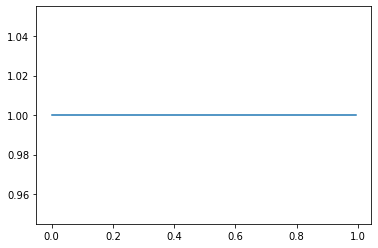

In [59]:
plt.plot(time, l)

In [0]:
from tqdm import tqdm

In [0]:
K.clear_session()

In [0]:
#Parameters of model
model_name = "LSTM"
optimizer_name = "sgd"
training_epochs = 200
batch_size = 1024
layers = 1
units = 95
learning_rate = 0.1
activation = "relu"
features = train_X.shape[-1]

In [0]:
def vanilla_RNN(layers, units, features):
    inp = Input([window, features])
    X = inp
    for i in range(layers - 1):
      X = LSTM(units, return_sequences = True)(X)
    X = LSTM(units)(X)
    out = Dense(len(source_Y), kernel_initializer = 'normal')(X)
    
    model = Model(inputs = inp, outputs = out)
    #Set up the Optimizers
    sgd = optimizers.SGD(learning_rate)
    adam = optimizers.Adam(lr = learning_rate)
    rmsprop = optimizers.RMSprop(lr = learning_rate)

    #Compile the model
    model.compile(loss = "mse", optimizer = sgd , metrics=["mse"])
    return model 
    
    

In [28]:
#Define Keras Model 
model = vanilla_RNN( layers, units, features)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 64)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 95)                60800     
_________________________________________________________________
dense (Dense)                (None, 64)                6144      
Total params: 66,944
Trainable params: 66,944
Non-trainable params: 0
_________________________________________________________________


In [0]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()


In [31]:
#Set Up Tensorboard for visualisation for training
Name = "{} + optimizer_{} + batch_size_{} + epochs_{} + Layer_{} + units_{} + learning_rate_{} +  activation_{} + relation_{} + date_".format(model_name, optimizer_name, batch_size, training_epochs, layers, units, learning_rate, activation, relation)
logdir ="logs/scalars/"+ Name + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TrainValTensorBoard(log_dir=logdir, write_images = True, histogram_freq = 2)
#Sanity Check for LogDir
print(logdir)

NameError: ignored

In [32]:
LOG_DIR = 'logs/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
#Get url of TensorBoard to Visualise
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
training_epochs = 200


In [34]:
#Fit the model with the Data

history = model.fit(
    x_train, 
    y_train, 
    validation_data= (x_valid, y_valid),
    batch_size = batch_size,
    epochs = training_epochs,
    verbose = 1,
    )


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 129360 samples, validate on 15960 samples
Epoch 1/200
129360/129360 [==============================] - 36s 277us/sample - loss: 0.8695 - mean_squared_error: 0.8695 - val_loss: 0.7899 - val_mean_squared_error: 0.7899
Epoch 2/200
129360/129360 [==============================] - 34s 265us/sample - loss: 0.7521 - mean_squared_error: 0.7521 - val_loss: 0.7158 - val_mean_squared_error: 0.7158
Epoch 3/200
129360/129360 [==============================] - 34s 265us/sample - loss: 0.6981 - mean_squared_error: 0.6981 - val_loss: 0.6755 - val_mean_squared_error: 0.6755
Epoch 4/200
129360/129360 [==============================] - 34s 263us/sample - loss: 0.6624 - mean_squared_error: 0.6624 - val_loss: 0.6444 - val_mean_squared_error: 0.6444
Epoch 5/200
129360/129360 [==============================] - 34s 263us/sample - loss: 0.6328 - mean_squared_error: 0.6328 - val_loss: 0.6175 - val_mean_squared

In [21]:
predictions = model.predict(x_test, verbose  = 1)




15960/15960 [==============================] - 21s 1ms/sample


In [0]:
def compute_correlation(true, pred):
    corr_coef = np.corrcoef(true, pred)[0, 1]
    return corr_coef 
    

In [23]:
predictions.shape, y_test.shape

((15960, 64), (15960, 64))

In [24]:
compute_correlation(y_test, predictions)

0.7774253406510199

In [0]:
def list_correlation(electi, true, pred):
    l = []
    for i in range(true.shape[-1]):
        l.append(compute_correlation(true[:, i], pred[:,i]))
    return l

In [0]:
k = list_correlation(electi, y_test, predictions)

In [27]:
k

[0.6342512791736576,
 0.721923791206957,
 0.6807324278449047,
 0.8882211603040994,
 0.8103091413856236,
 0.743317954165881,
 0.8520538290134588,
 0.869992054985196,
 0.8642312252238192,
 0.6403473961374687,
 0.9024445520603898,
 0.9061129755990902,
 0.8951967512844763,
 0.8563098813937989,
 0.7251747873530398,
 0.7761173769426924,
 0.8851409219493299,
 0.9087505864623349,
 0.9167145515547567,
 0.9296491885845126,
 0.5428525988179983,
 0.9228324259966021,
 0.8766375911685761,
 0.8282636158005867,
 0.8979420170234748,
 0.9026086469402455,
 0.8879417018518168,
 0.5531286009068603,
 0.8227767112237978,
 0.9345275164080721,
 0.9289857775391902,
 0.8962341880002737,
 0.6599908150172774,
 0.5387073900809616,
 0.5802244579095948,
 0.5855503602469407,
 0.8225248583510615,
 0.8940536260492395,
 0.8687986996820364,
 0.8263412554569226,
 0.6454352561698411,
 0.839244199490511,
 0.8163684638247306,
 0.8564847895927492,
 0.6631455774934604,
 0.8948225713130452,
 0.9119102752128176,
 0.90730122333175

In [0]:
def convert_to_csv():
  frame = pd.DataFrame()

In [0]:
#Graphical Display to plot weights
def plot_weights(weights, electi):
 
        
    T = np.arange(0, 0.00625*stim, 0.00625)                       # creation of the time variable (on 1s) for the abscissa
    
    nbr_elct = len(electi)
    (Lo_W, la_W) = weights[0].shape
    Lo_W = int(Lo_W)                                              # number of lines: inputs (160 * nbr_electrodes, for example)
    la_W = int(la_W)                                              # number of columns: number of neurons in the layer
    
    z=0
    while z < nbr_elct:                                           # for each electrode
        z_1=0 
        while z_1 < la_W:                                         # for each neuron of the W layer [1]
            W_tmp = tf.slice(K.constant(weights[0]), [0, z_1], [Lo_W, 1])           # slice: starting value [line 0, column of the neuron], dimensions of the section [160 * nbr_electrodes lines, 1 column])
            W_tmp = tf.slice(W_tmp, [z*stim, 0], [stim, 1])       # slice: starting value [first value of the new electrode, column 0], dimensions of the section [160 lines, 1 column]
            print (W_tmp.shape)
            
            plt.plot(T, K.eval(W_tmp), label= ("neurone_", z_1, "layer_1, electrode_", electi[z]))
            z_1 = z_1+1
            
        z = z+1
        
    plt.legend()    
    plt.show()
    

(160, 1)


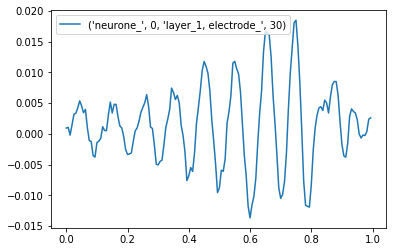

In [0]:
weights = np.array(model.get_weights()) #Convert the weights into np array

plot_weights(weights, electi)            #Plot the weights of the model

In [0]:
weights.shape

(2,)